In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Input

In [2]:
data_dir =r"E:\1. Thesis\Update_Code\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [3]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

In [4]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [5]:
def load_images_for_cnn(train_df, 
                        val_df, 
                        test_df, 
                        batch_size=32, 
                        target_size=(224,224)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df,
                                                                        val_df, 
                                                                        test_df, 
                                                                        batch_size=32, 
                                                                        target_size=(224,224))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [7]:
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224,224,3))
#Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
predictions=Dense(8,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=predictions)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
epochs=10
history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 610s 7s/step - accuracy: 0.3205 - loss: 1.9049 - val_accuracy: 0.4387 - val_loss: 1.6339
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.8864 - loss: 0.8478 - val_accuracy: 0.5825 - val_loss: 1.2668
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step - accuracy: 0.9463 - loss: 0.4447 - val_accuracy: 0.6438 - val_loss: 1.0554
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - accuracy: 0.9669 - loss: 0.2519 - val_accuracy: 0.6862 - val_loss: 0.9454
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 493s 7s/step - accuracy: 0.9749 - loss: 0.1664 - val_accuracy: 0.7138 - val_loss: 0.8365
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 461s 6s/step - accuracy: 0.9844 - loss: 0.1061 - val_accuracy: 0.7525 - val_loss: 0.7237
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 489s 6s/step - accuracy: 0.9864 - loss: 0.0901 - val_accuracy: 0.7912 - val_loss: 0.6424
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 569s 8s/step - accuracy: 0.9944 - loss: 0.0597 - val_accuracy: 0.8188 - v

In [16]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 994ms/step - accuracy: 0.8721 - loss: 0.4497
Test Loss: 0.4312862753868103, Test Accuracy: 0.8725000023841858


In [10]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
                  precision    recall  f1-score   support

     Anthracnose       0.80      0.95      0.87       117
Bacterial Canker       1.00      0.54      0.70       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       0.97      1.00      0.98        97
      Gall Midge       0.63      0.98      0.77       107
         Healthy       0.90      0.70      0.79        77
  Powdery Mildew       0.98      0.95      0.96        98
     Sooty Mould       0.97      0.82      0.89        91

        accuracy                           0.87       800
       macro avg       0.91      0.87      0.87       800
    weighted avg       0.90      0.87      0.87       800



In [11]:
test_predictions=model.predict(test_generator)
test_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


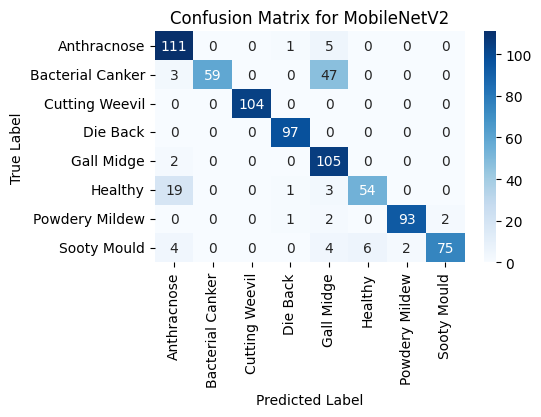

In [12]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,test_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MobileNetV2')
plt.show()

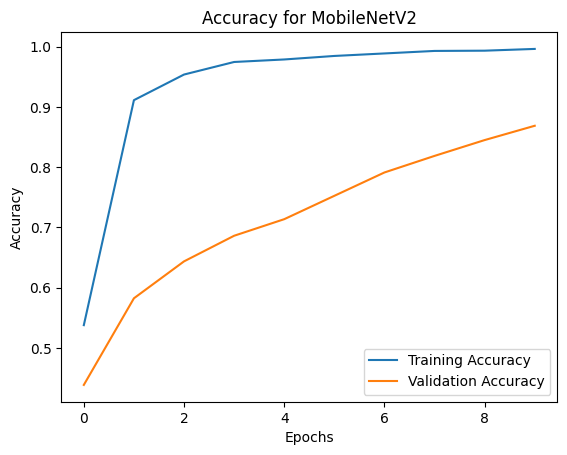

In [13]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for MobileNetV2')
plt.legend()
plt.show()

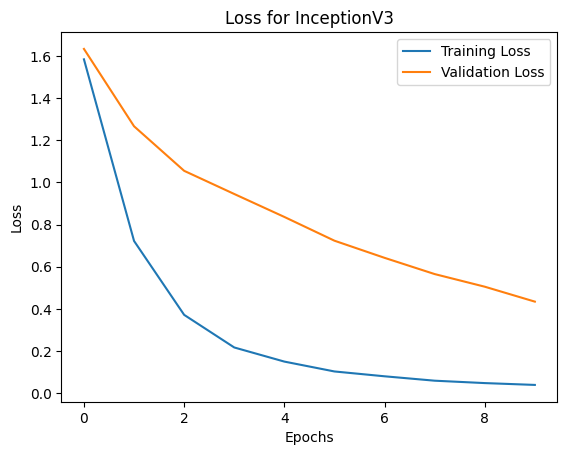

In [14]:
#plot training and validation loss
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for InceptionV3')
plt.legend()
plt.show()